# Part 3 - SqueezeNet

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the data and labels
file_path = os.path.join('/content/drive/MyDrive/Colab_Notebooks/', 'processed_data.npz')
loaded = np.load(file_path, allow_pickle=True)
data_list = loaded['data']
label_list = loaded['labels']

input_shape = data_list.shape[1:]  # (height, width, channels)
num_classes = len(np.unique(label_list))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_list, label_list, test_size=0.2, random_state=42)

In [ ]:
print(type(data_list))
print(type(label_list))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split

class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

#model
class SqueezeNetRegression(nn.Module):
    def __init__(self):
        super(SqueezeNetRegression, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=(7, 3), stride=(2, 1), padding=(3, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(96, 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(64, 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(64, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 48, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 48, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(256, 75, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = x.view(x.size(0), -1)
        return x

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.float().unsqueeze(1)  # Add channel dimension
            labels = labels.float().view(labels.size(0), -1)  # Flatten labels

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

    return model

data = np.load('/content/drive/MyDrive/Colab_Notebooks/processed_data.npz')
ecg_data = data['data']
activation_times = data['labels']

#train and validation
ecg_train, ecg_val, labels_train, labels_val = train_test_split(ecg_data, activation_times, test_size=0.2, random_state=42)

train_dataset = ECGDataset(ecg_train, labels_train)
val_dataset = ECGDataset(ecg_val, labels_val)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False)
}

#model, criterion, and optimizer
model = SqueezeNetRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#train
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)


Epoch 0/24, Loss: 1441.6458
Epoch 1/24, Loss: 818.5366
Epoch 2/24, Loss: 584.4341
Epoch 3/24, Loss: 472.8592
Epoch 4/24, Loss: 375.4918
Epoch 5/24, Loss: 337.1021
Epoch 6/24, Loss: 317.1448
Epoch 7/24, Loss: 302.6278
Epoch 8/24, Loss: 293.4472
Epoch 9/24, Loss: 286.5824
Epoch 10/24, Loss: 278.7541
Epoch 11/24, Loss: 273.9735
Epoch 12/24, Loss: 271.2998
Epoch 13/24, Loss: 263.8128
Epoch 14/24, Loss: 259.6475
Epoch 15/24, Loss: 257.1129
Epoch 16/24, Loss: 253.8764
Epoch 17/24, Loss: 249.9176
Epoch 18/24, Loss: 245.3875
Epoch 19/24, Loss: 242.3353
Epoch 20/24, Loss: 241.7784
Epoch 21/24, Loss: 234.2486
Epoch 22/24, Loss: 232.3347
Epoch 23/24, Loss: 227.6682
Epoch 24/24, Loss: 226.3756


Case:  20


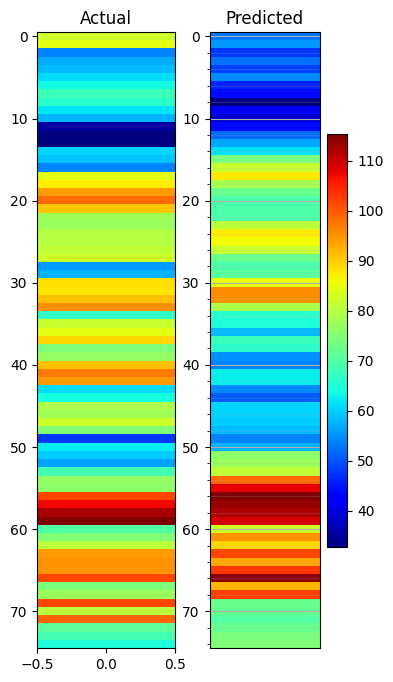

Case:  21


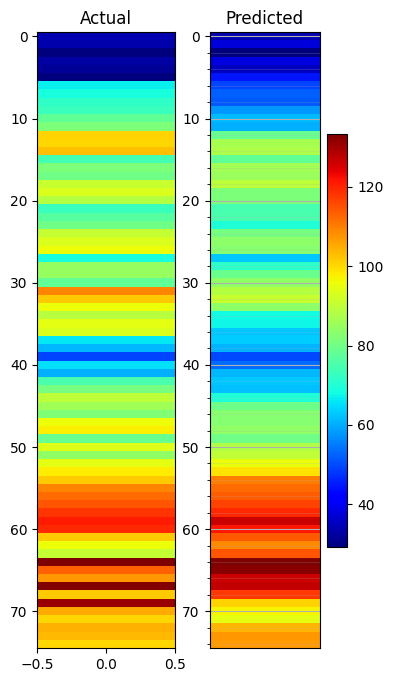

Case:  22


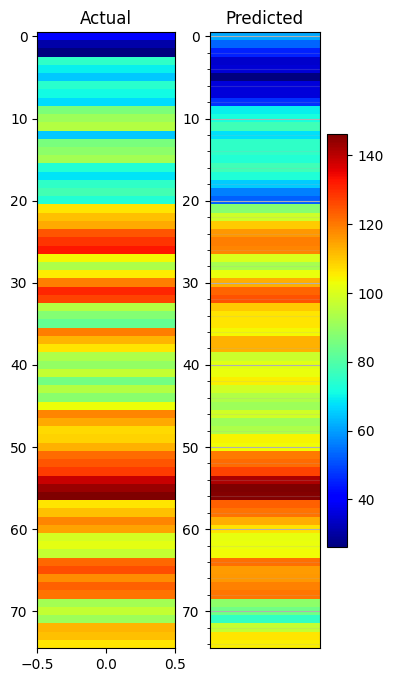

Case:  23


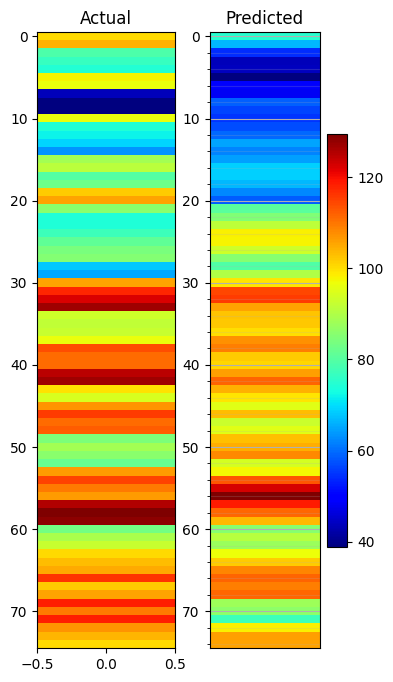

Case:  24


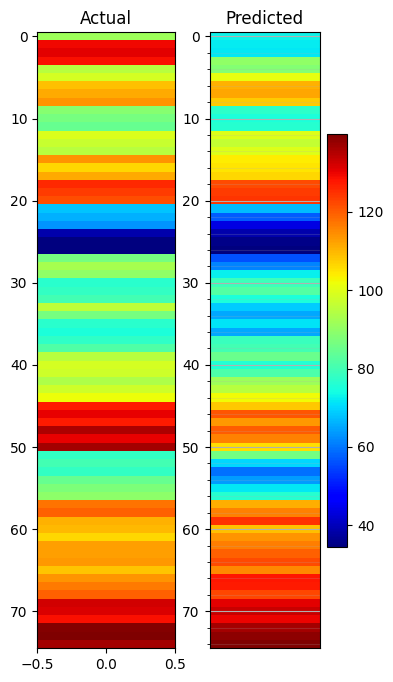

Case:  25


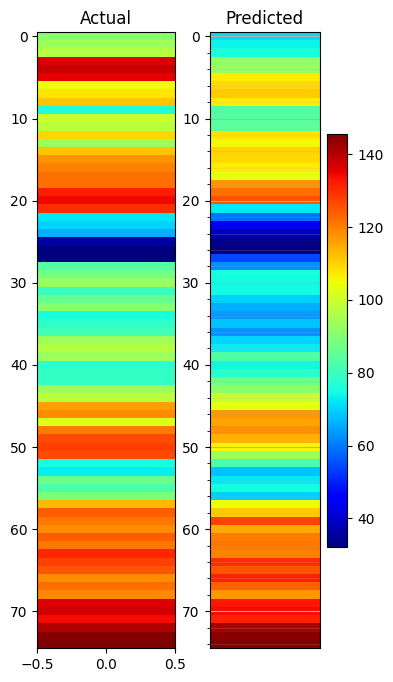

Case:  26


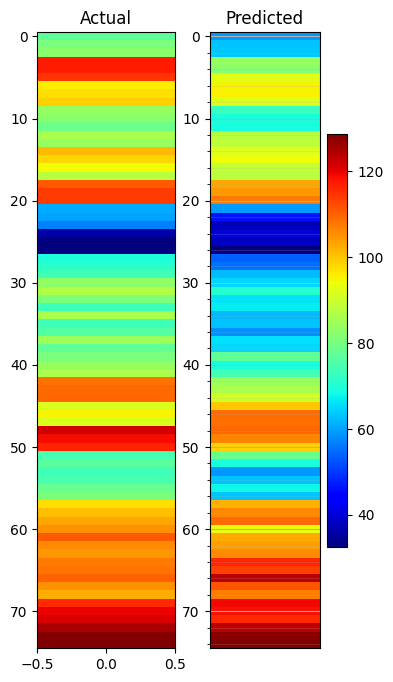

Case:  27


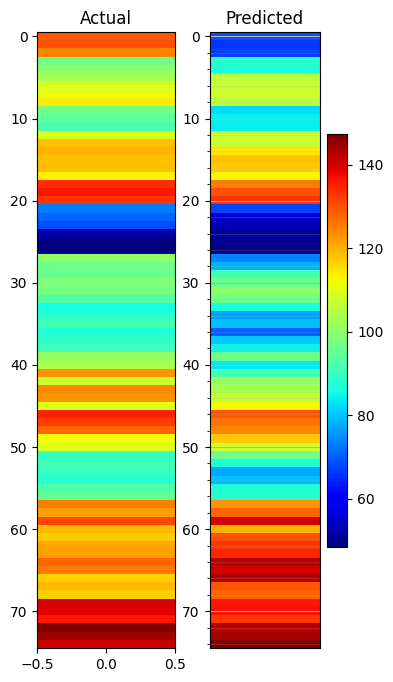

Case:  28


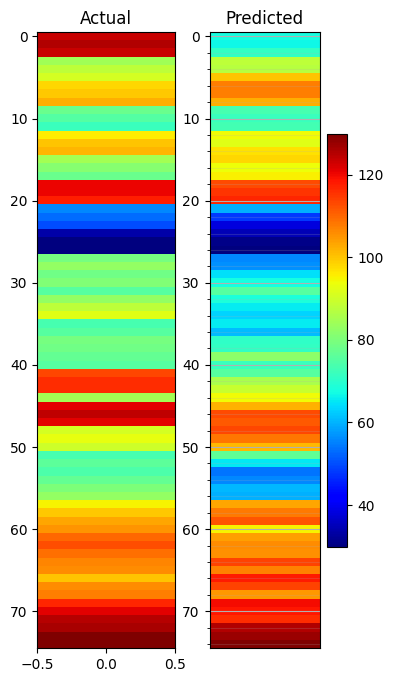

Case:  29


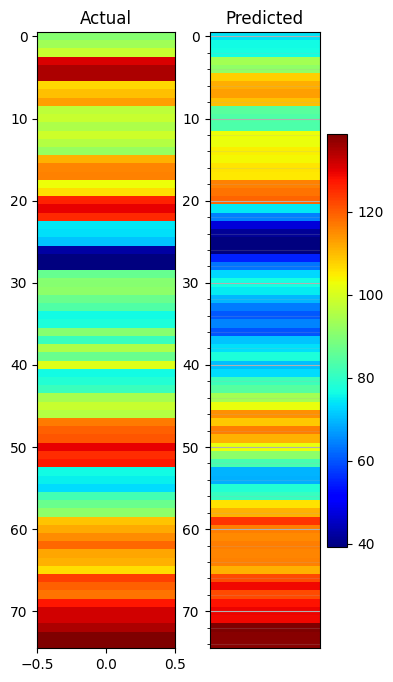

Case:  30


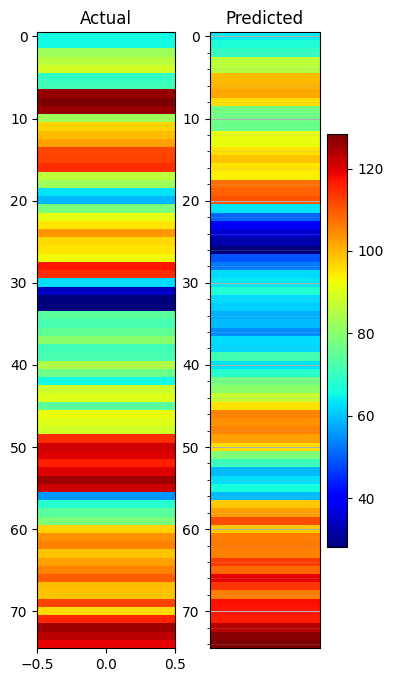

Case:  31


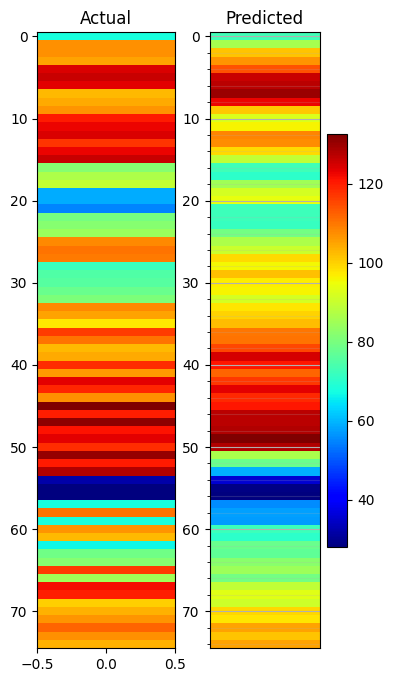

Case:  32


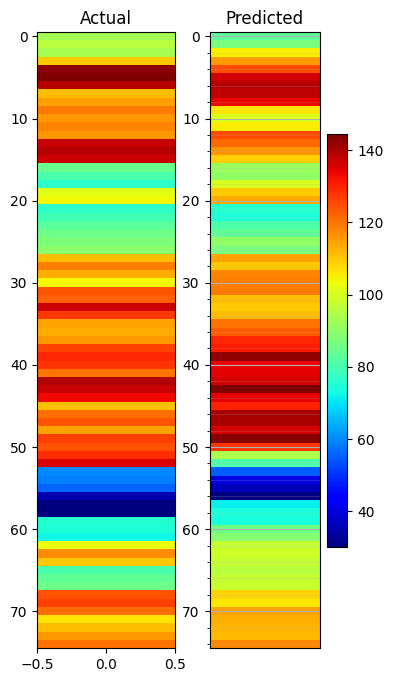

Case:  33


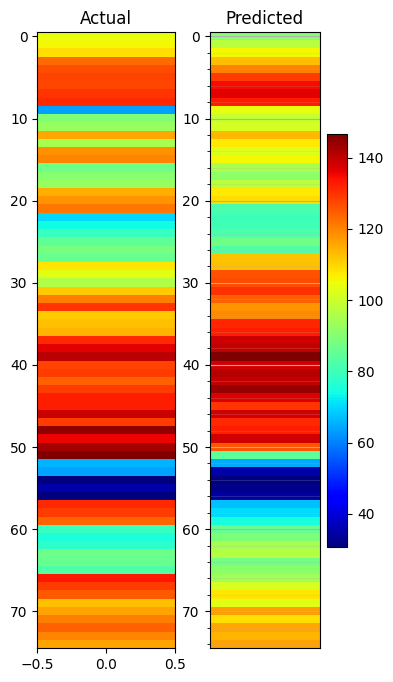

Case:  34


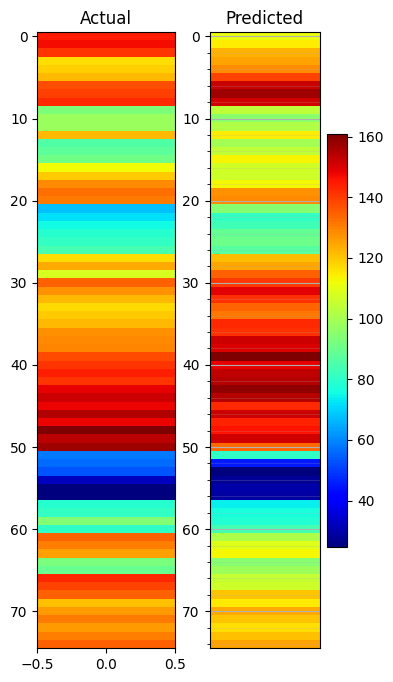

Case:  35


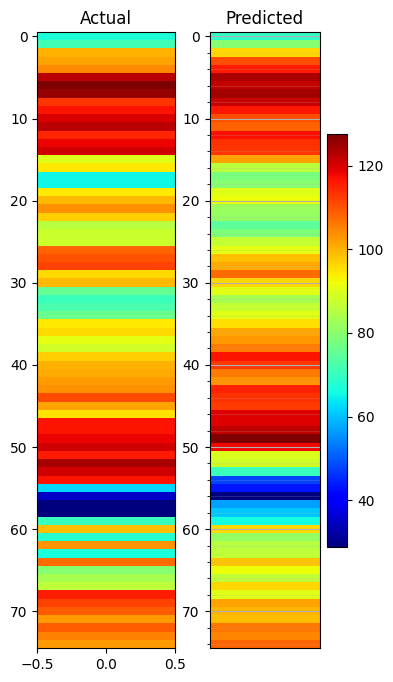

Case:  36


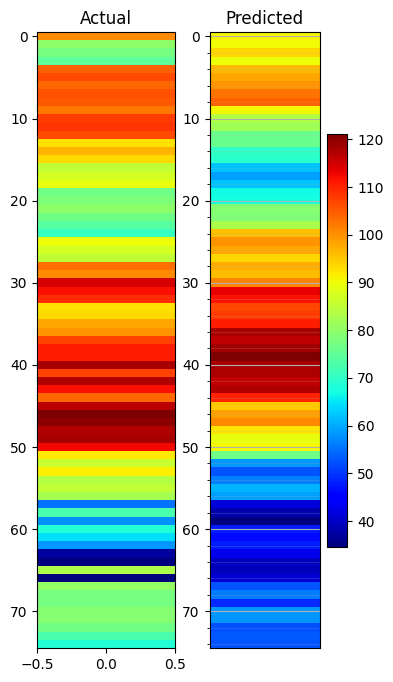

Case:  37


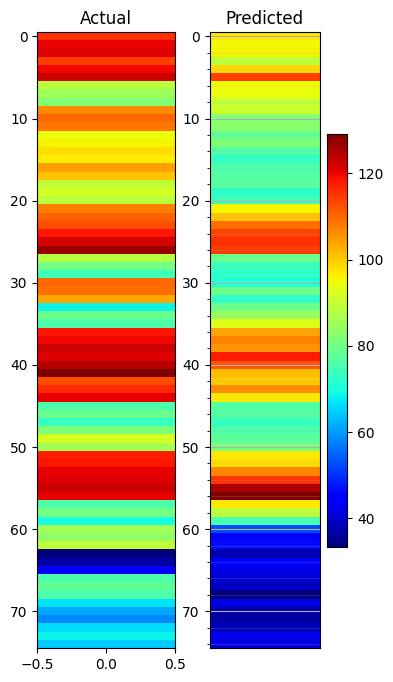

Case:  38


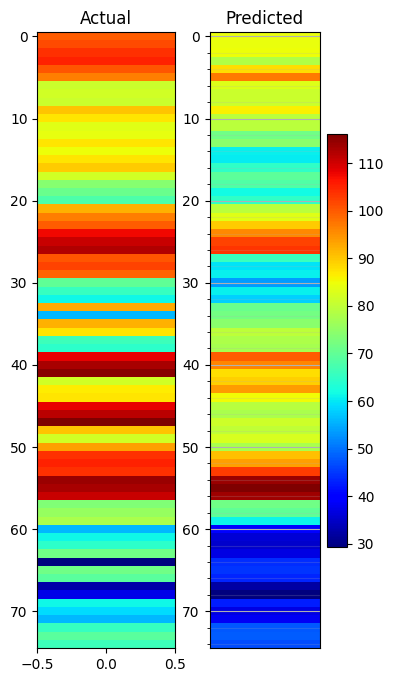

Case:  39


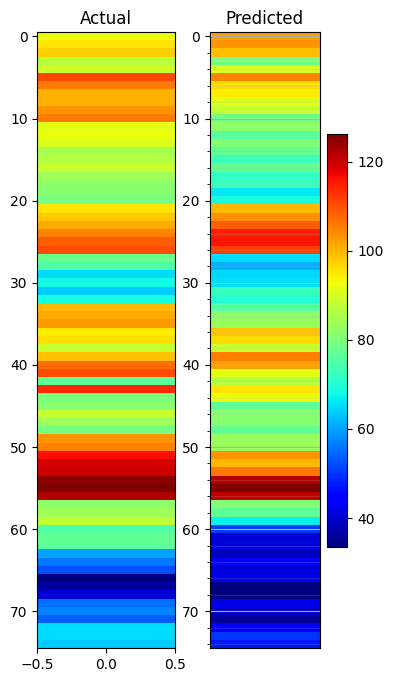

Case:  40


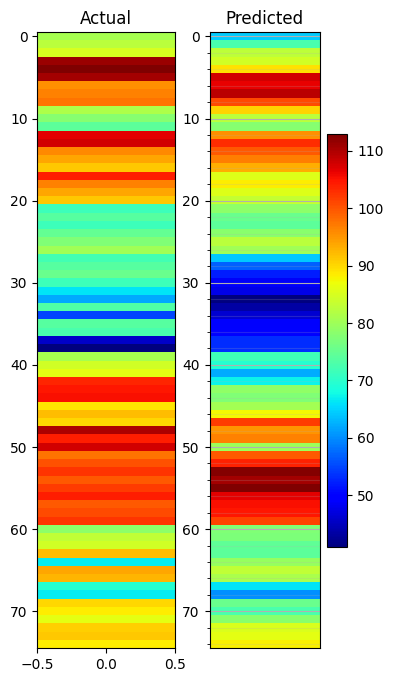

Case:  41


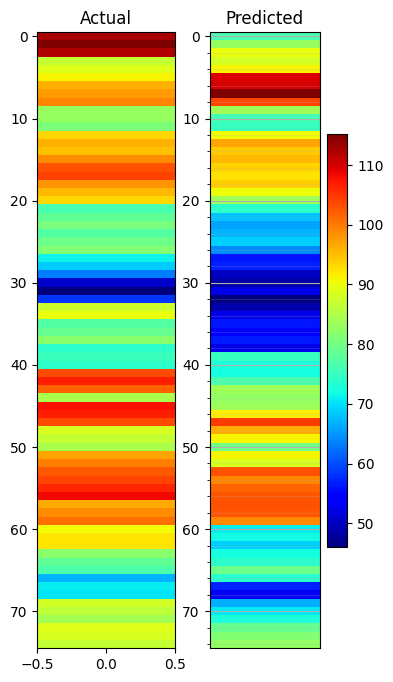

Case:  42


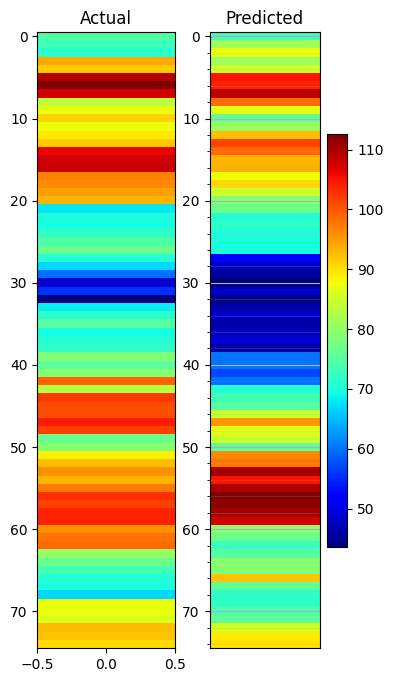

Case:  43


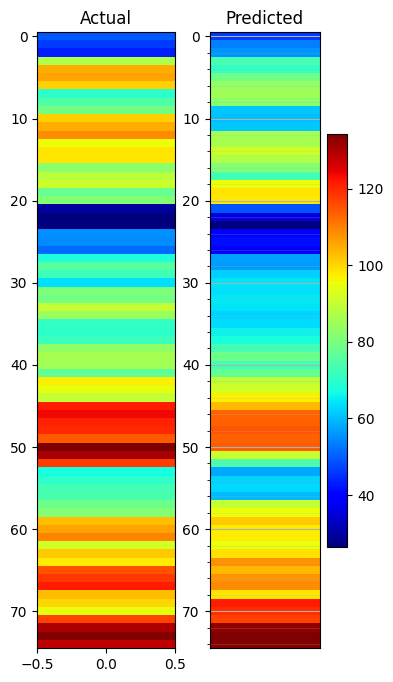

Case:  44


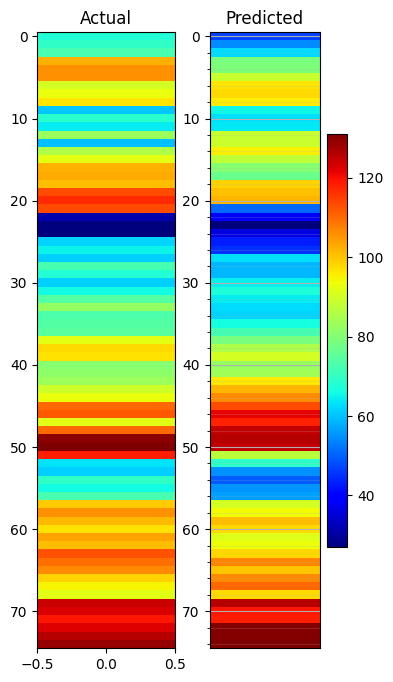

Case:  45


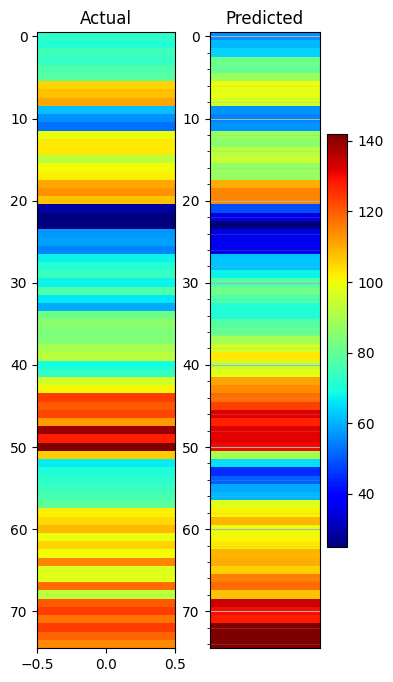

Case:  46


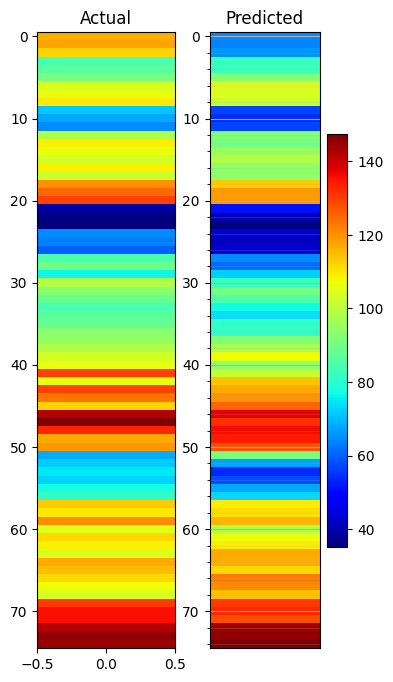

Case:  47


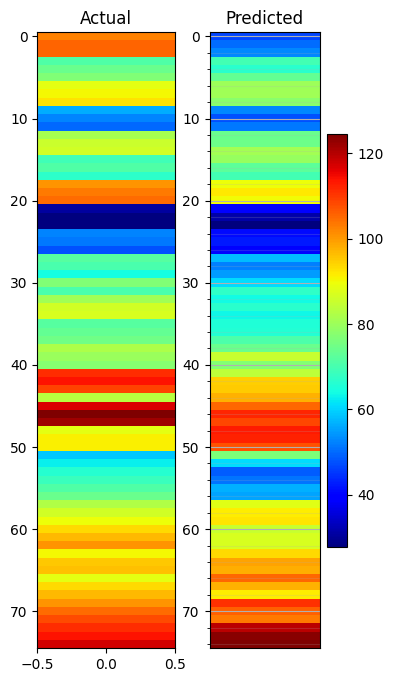

Case:  48


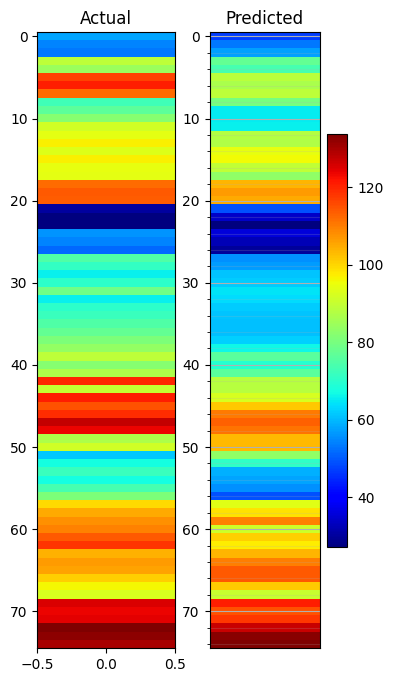

Case:  49


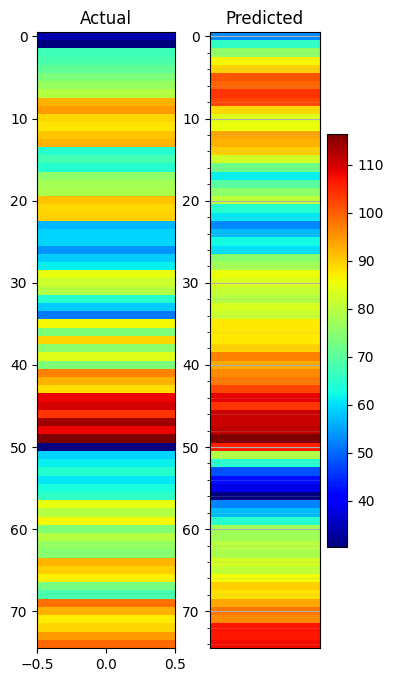

Case:  50


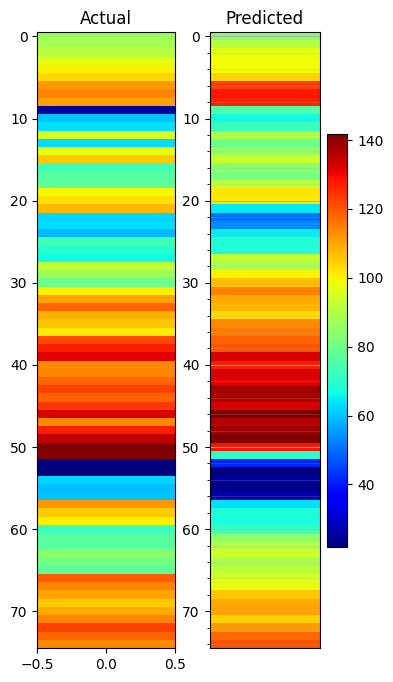

Case:  51


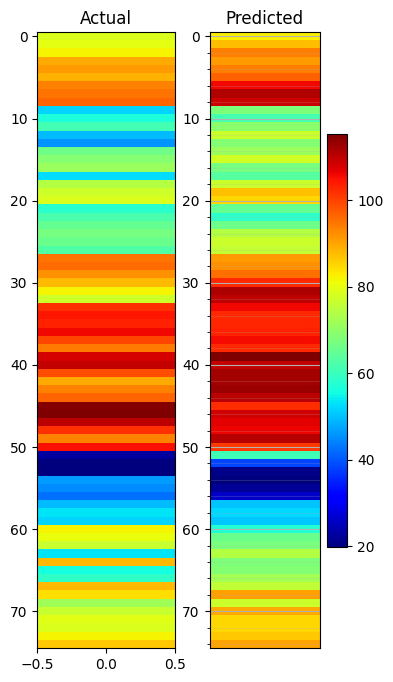

Case:  52


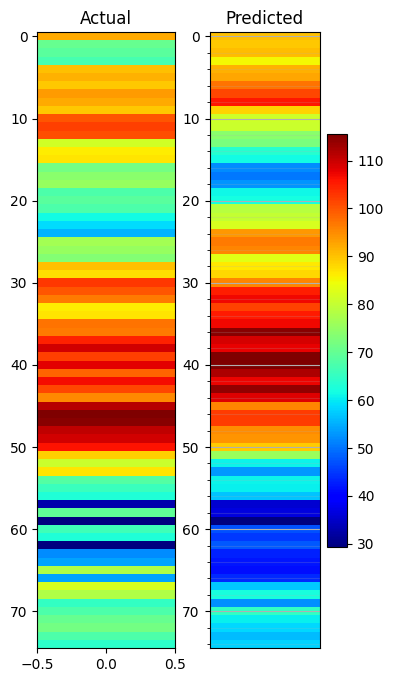

Case:  53


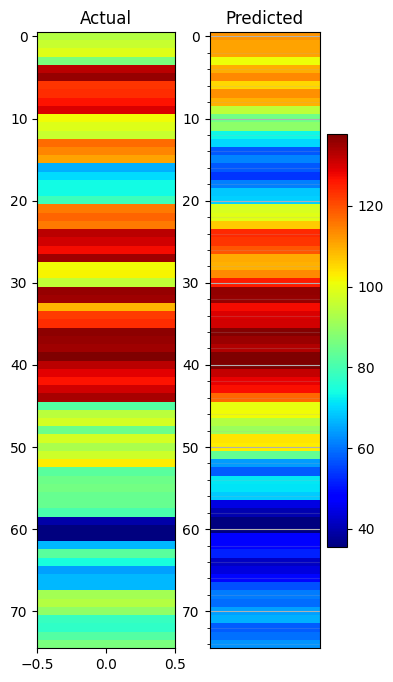

Case:  54


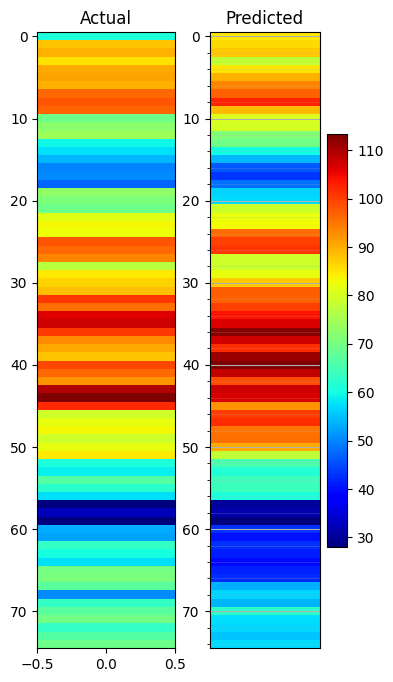

Case:  55


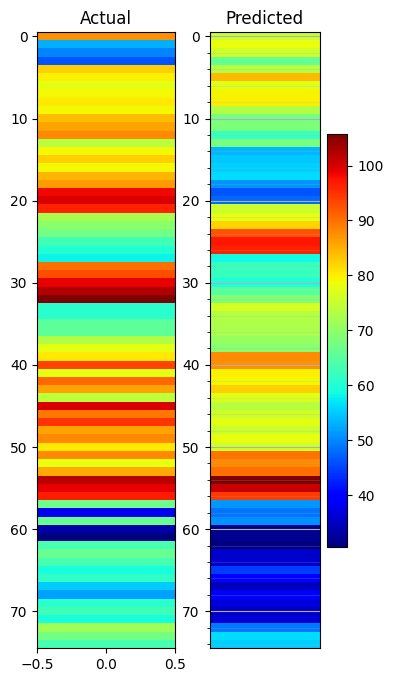

Case:  56


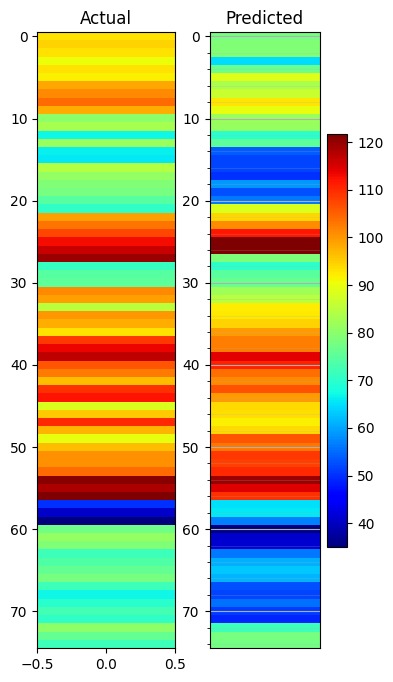

Case:  57


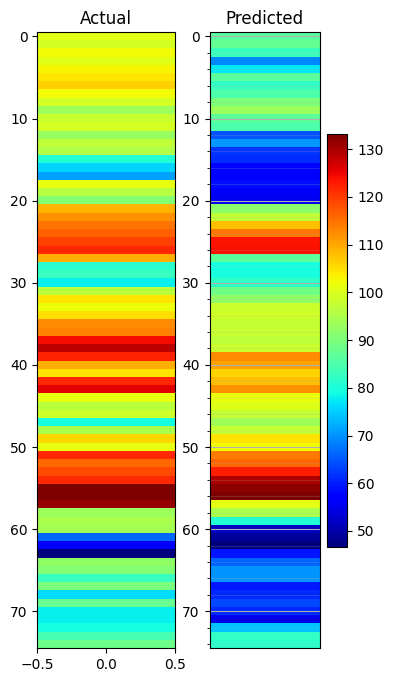

Case:  58


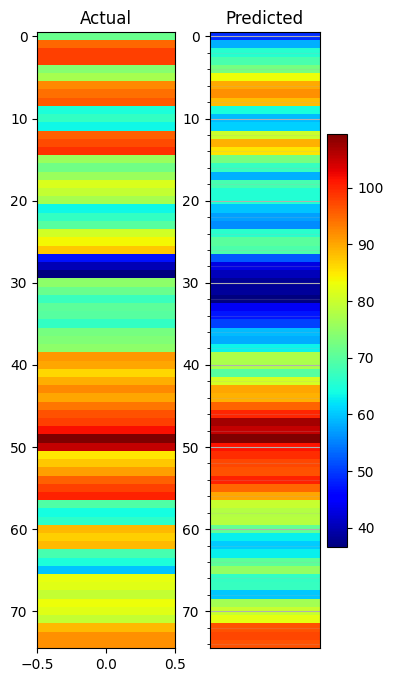

Case:  59


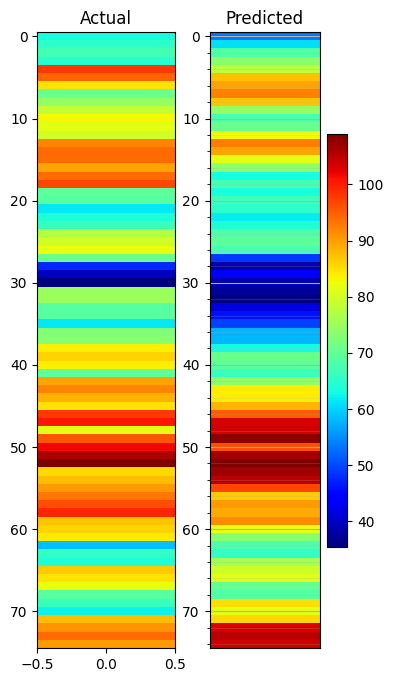

Case:  60


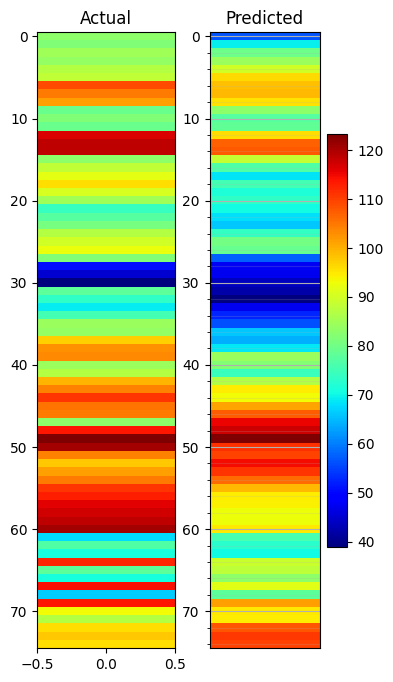

Case:  61


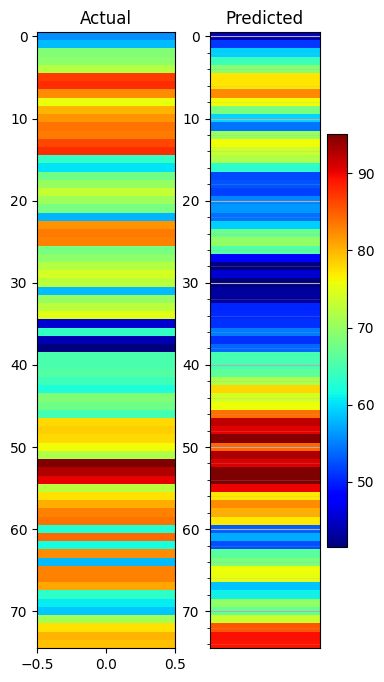

Case:  62


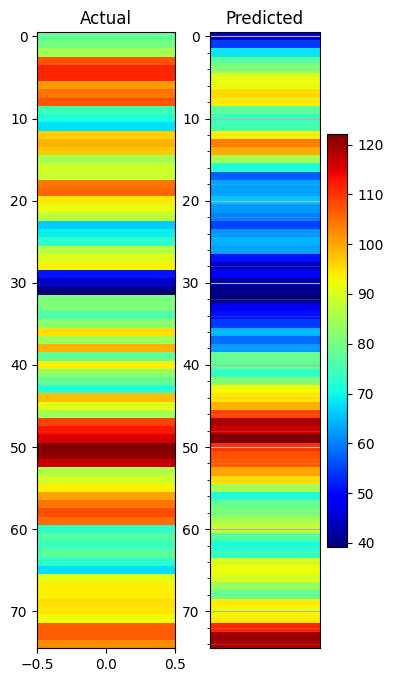

Case:  63


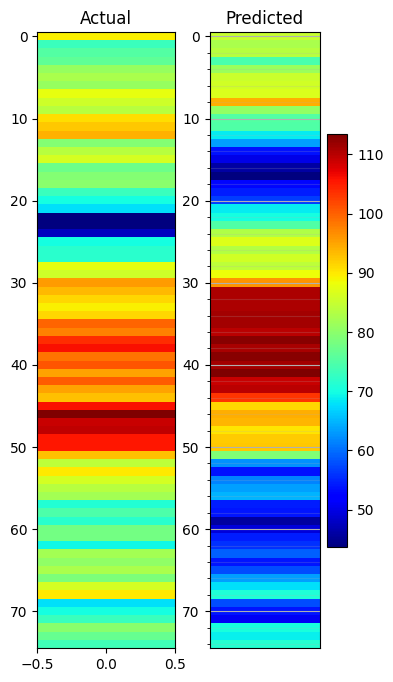

Case:  64


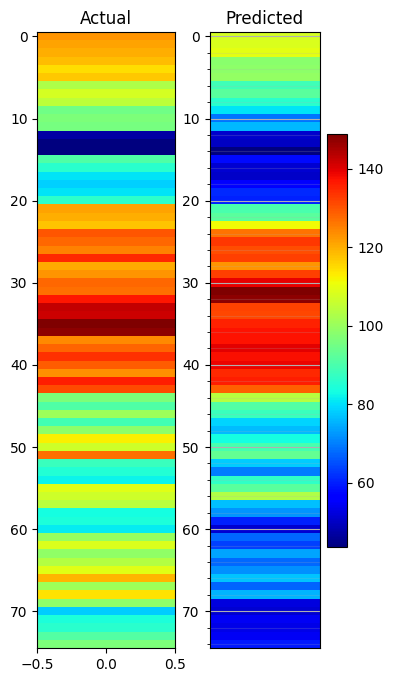

Case:  65


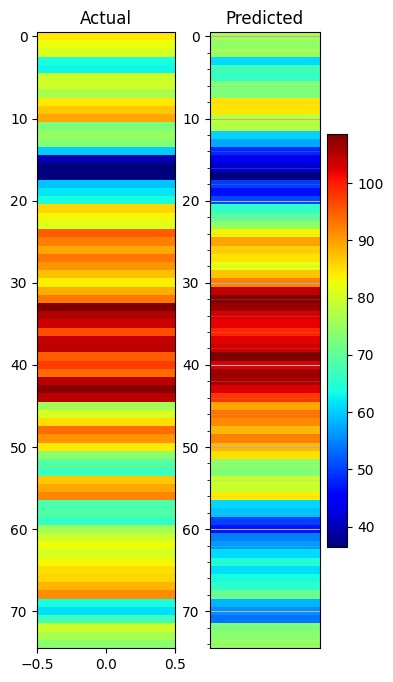

Case:  66


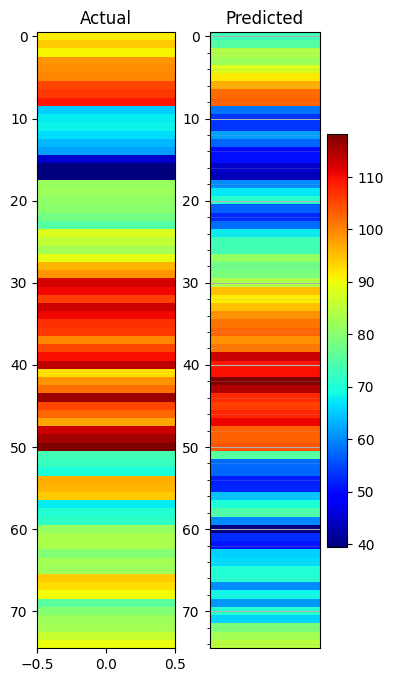

Case:  67


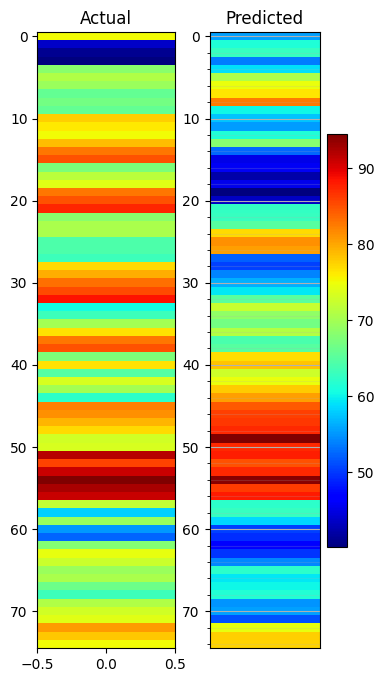

Case:  68


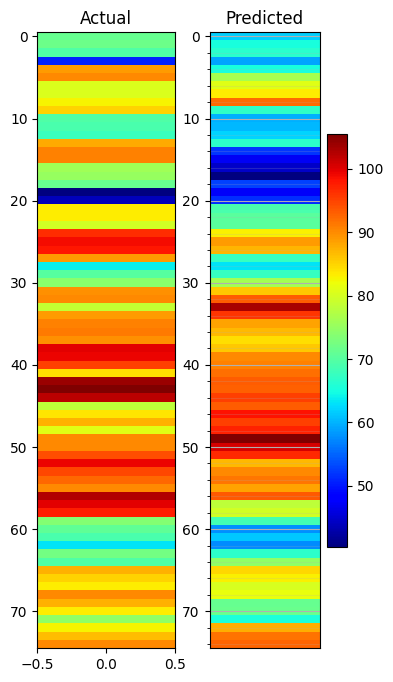

Case:  69


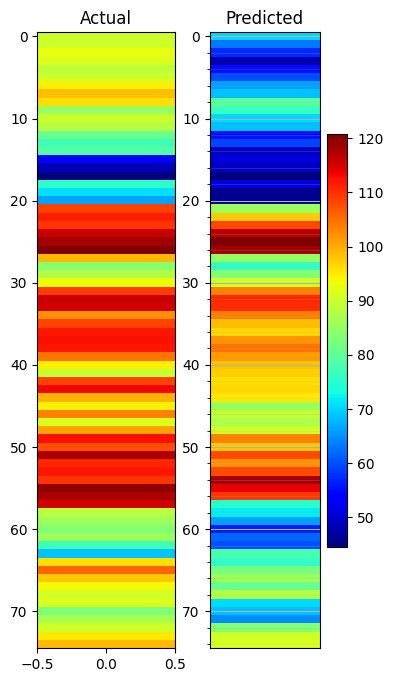

Case:  70


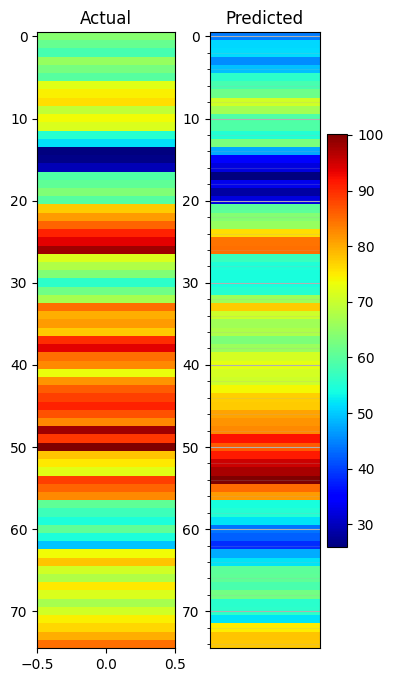

Case:  71


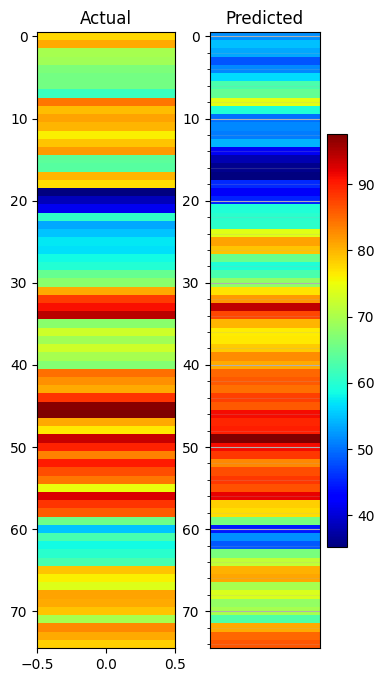

Case:  72


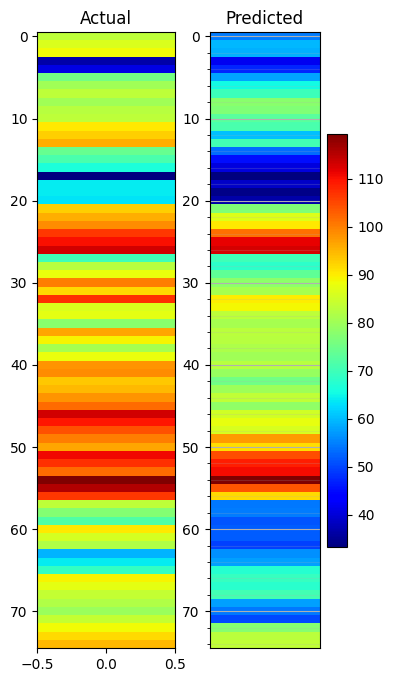

Case:  73


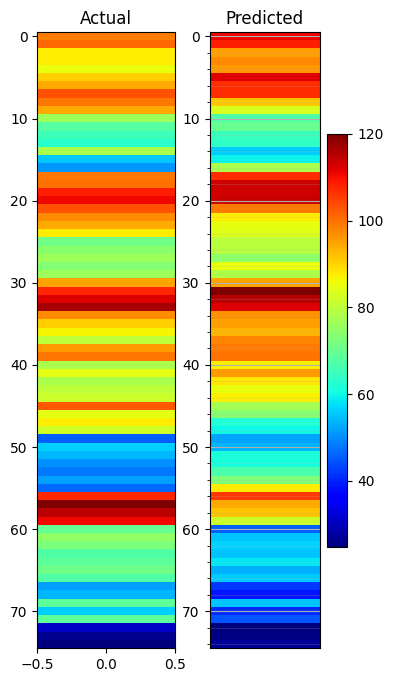

Case:  74


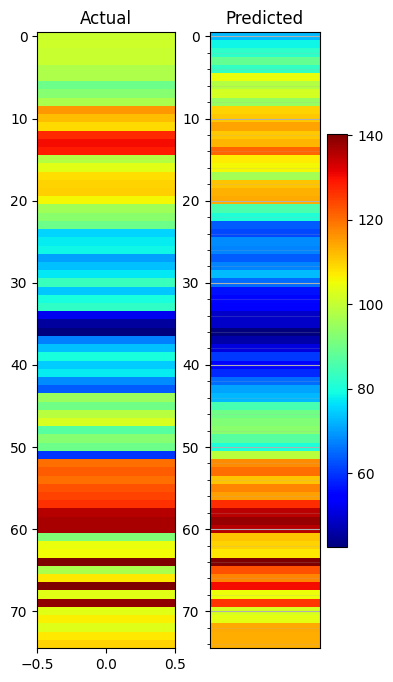

Case:  75


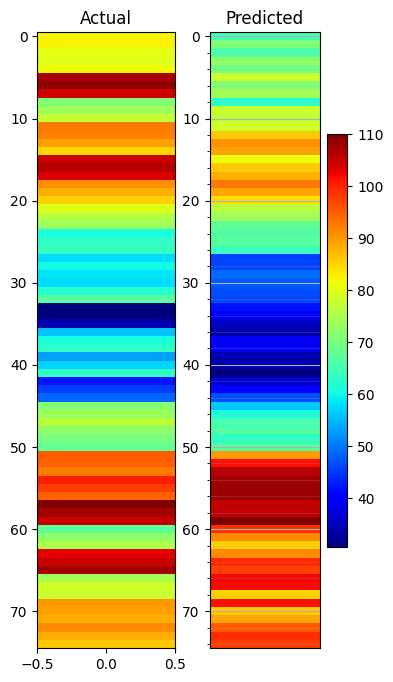

Case:  76


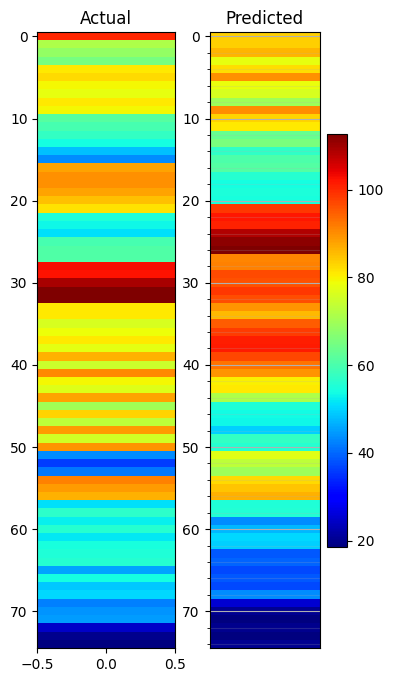

Case:  77


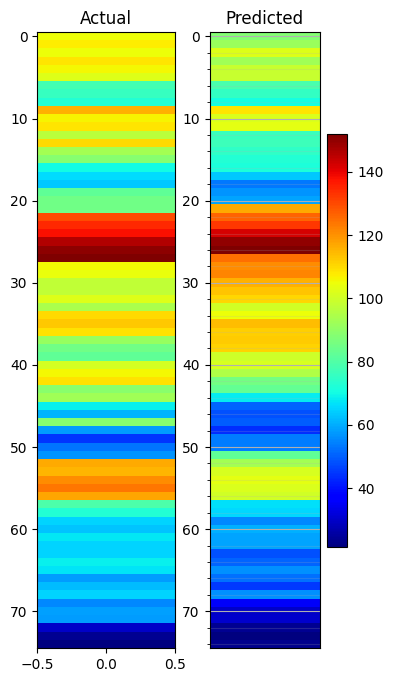

Case:  78


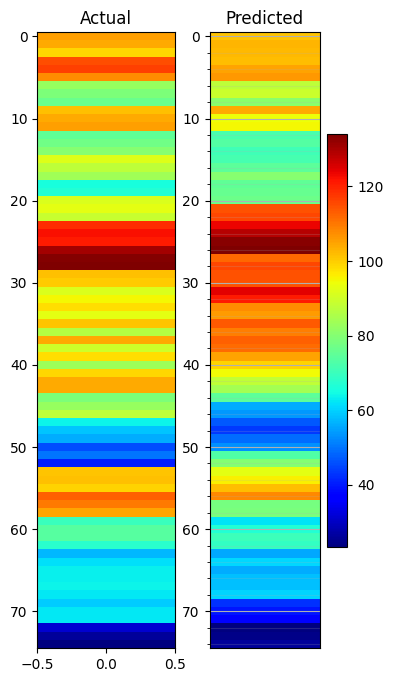

Case:  79


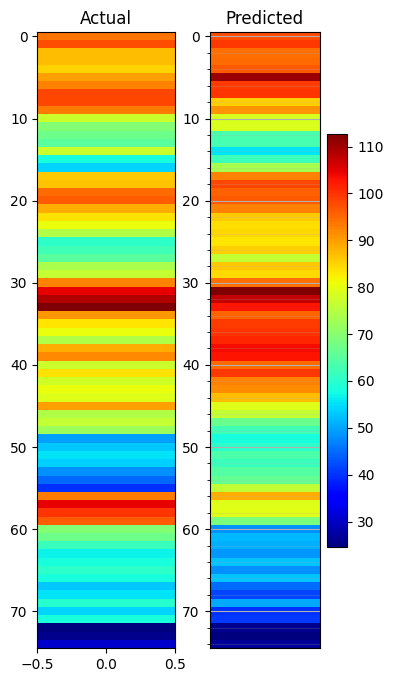

Case:  80


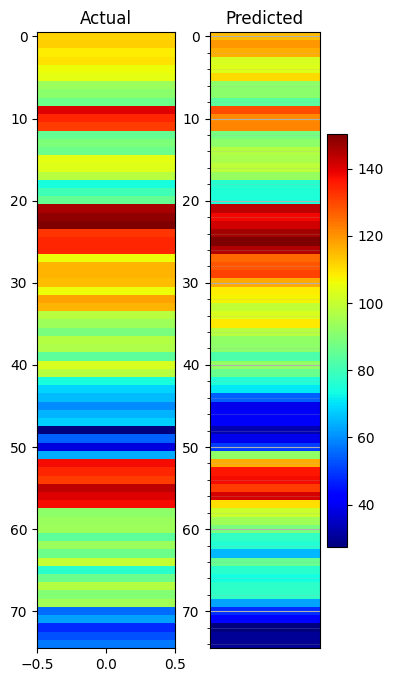

Case:  81


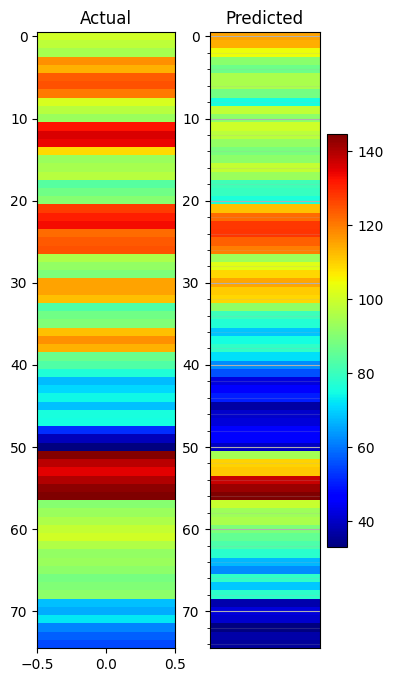

Case:  82


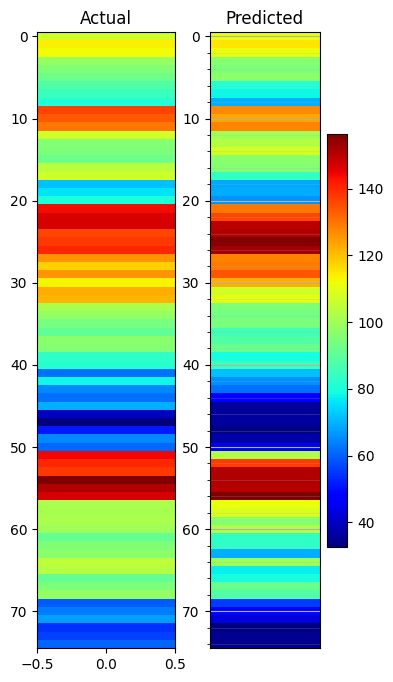

Case:  83


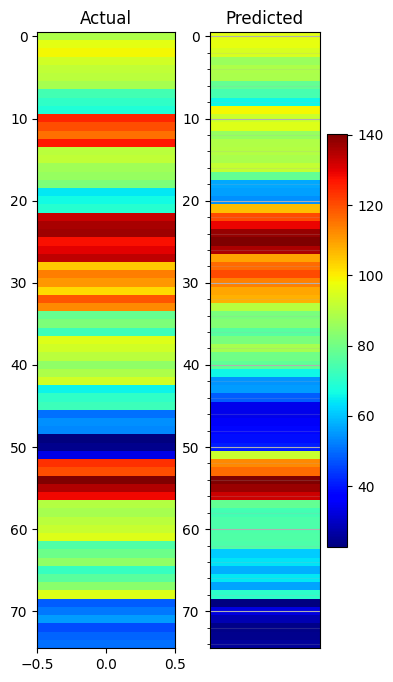

Case:  84


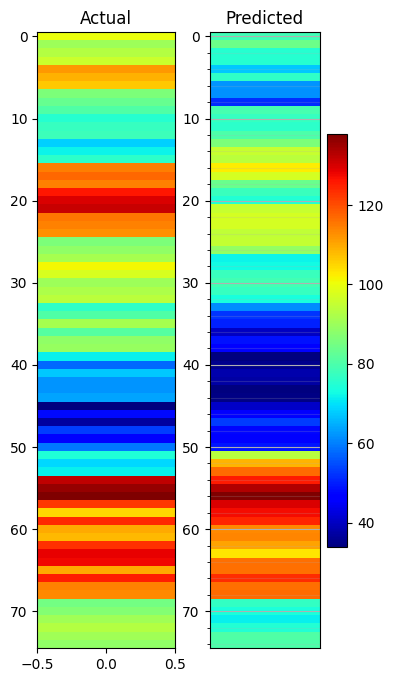

Case:  85


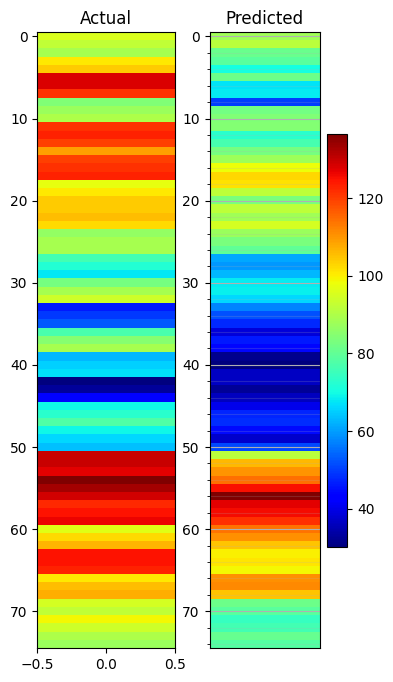

Case:  86


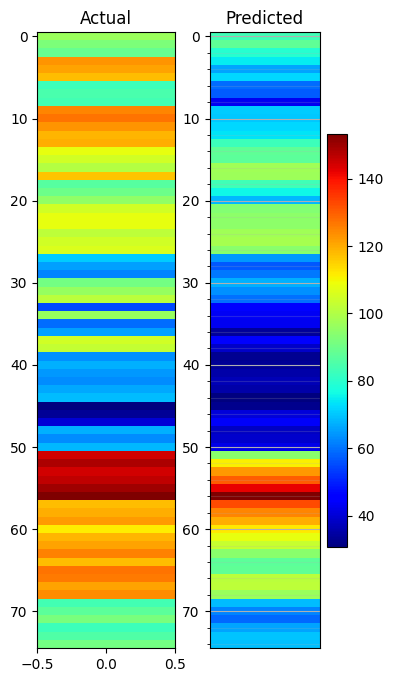

Case:  87


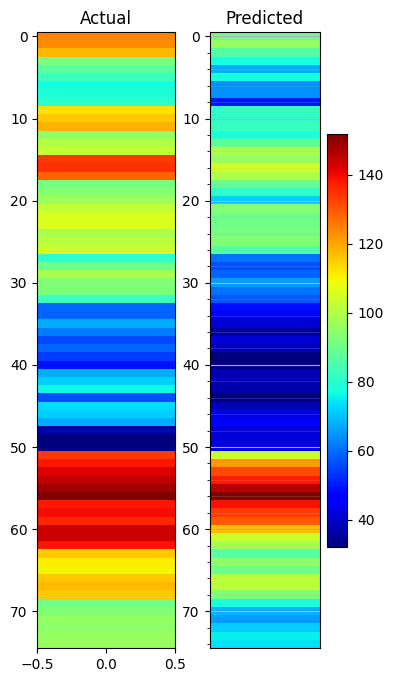

Case:  88


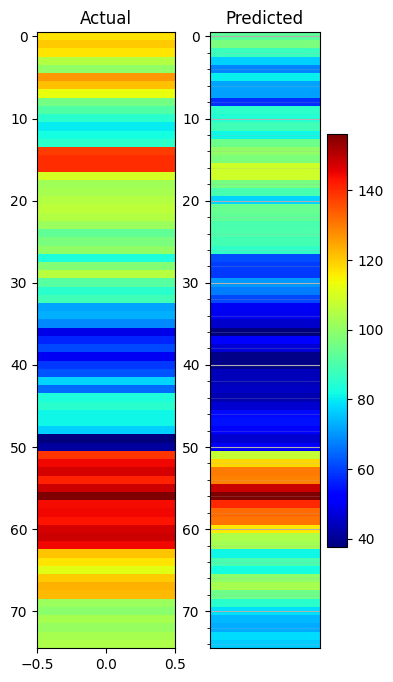

Case:  89


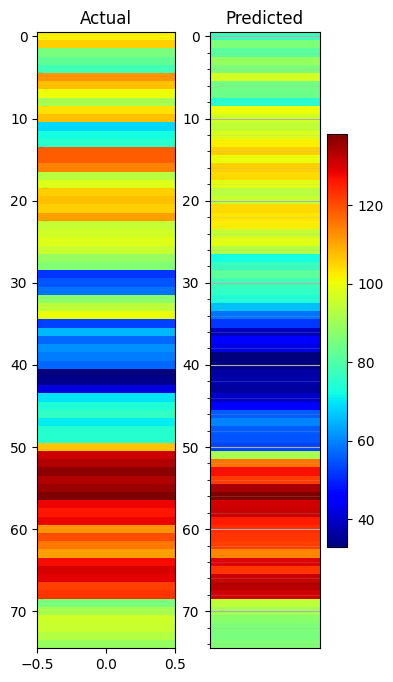

Case:  90


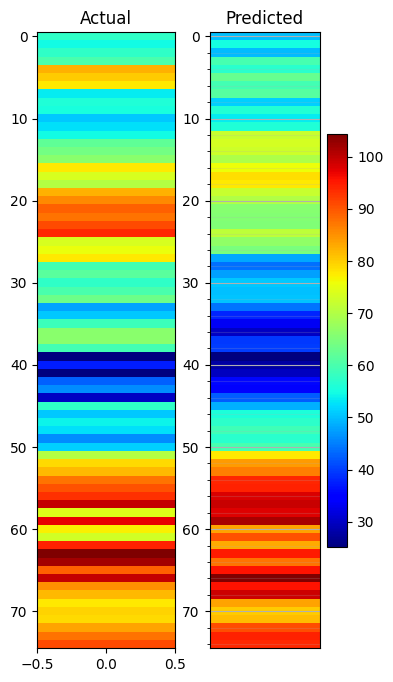

Case:  91


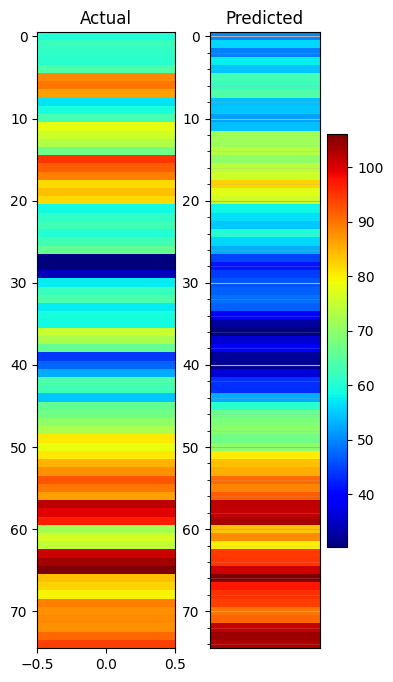

Case:  92


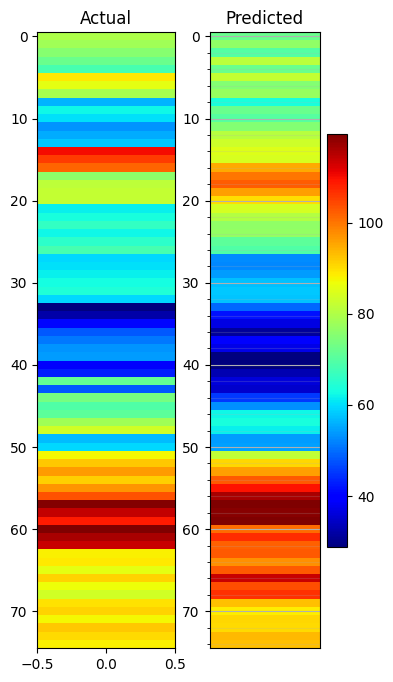

Case:  93


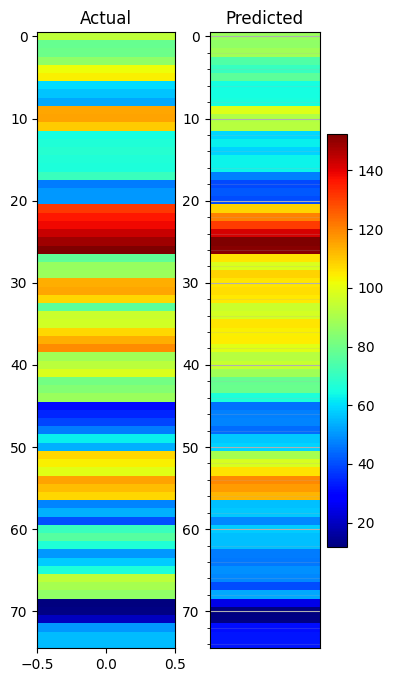

Case:  94


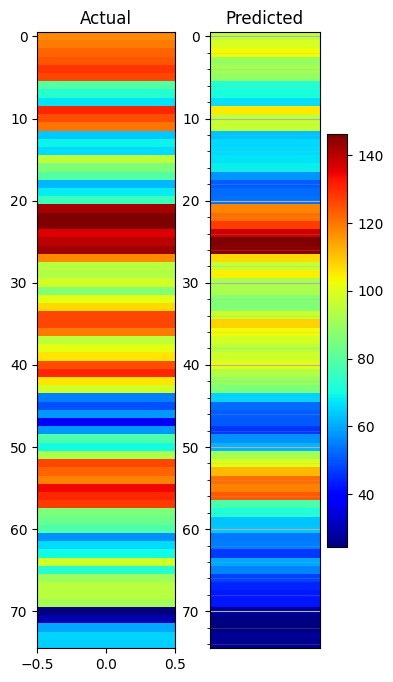

Case:  95


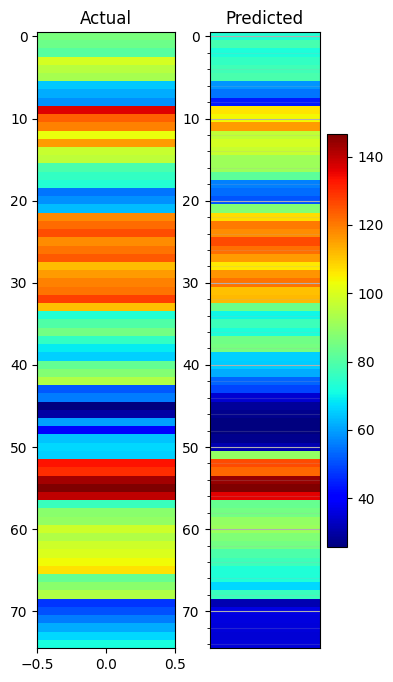

Case:  96


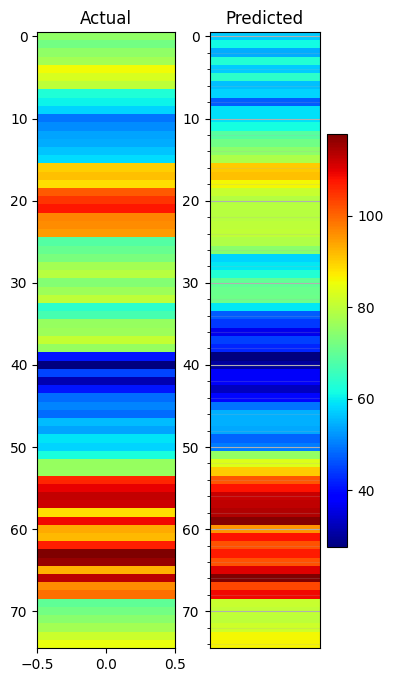

Case:  97


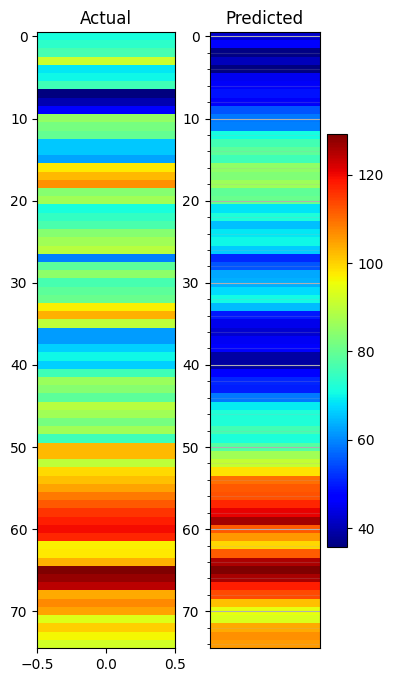

Case:  98


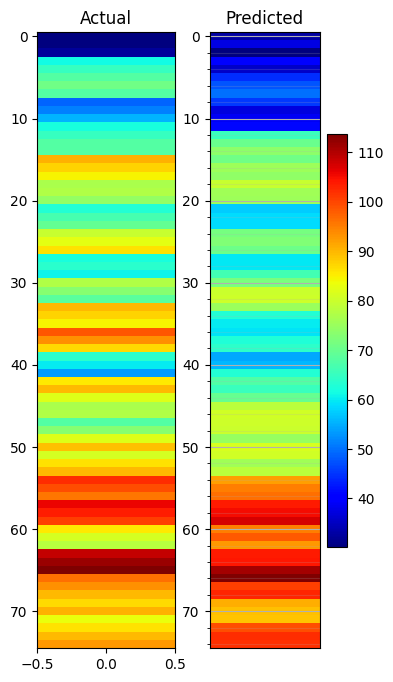

Case:  99


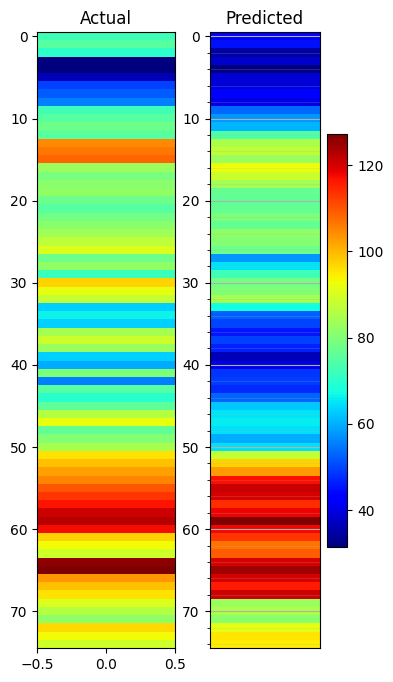

In [ ]:
import matplotlib.pyplot as plt

#get a single test case
def get_test_case(case_index):
    input_data = loaded['data']
    label_data = loaded['labels']
    input_data = input_data[case_index]
    label_data = label_data[case_index]
    return input_data, label_data

i = 20
while i < 100:
  #test case
  case_index = i
  input_data, actual_activation_time = get_test_case(case_index)

  #prepare data for model
  input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

  #eval mode
  model.eval()

  #get prediction
  with torch.no_grad():
      prediction = model(input_tensor).numpy().flatten()

  #plot actual act time
  plt.figure(figsize=(4, 8))
  plt.subplot(1, 2, 1)
  plt.imshow(actual_activation_time, cmap='jet', interpolation='nearest', aspect='auto')
  plt.title('Actual')

  #plot predicted act time
  plt.subplot(1, 2, 2)
  plt.imshow(prediction.reshape(actual_activation_time.shape), cmap='jet', interpolation='nearest', aspect='auto')
  plt.title('Predicted')
  plt.colorbar()
  plt.grid(visible=True, which='major', linestyle='-')
  plt.minorticks_on()
  plt.xticks([])
  plt.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

  print('Case: ', i)
  plt.subplots_adjust(wspace=0.25)
  plt.show()
  i+=1



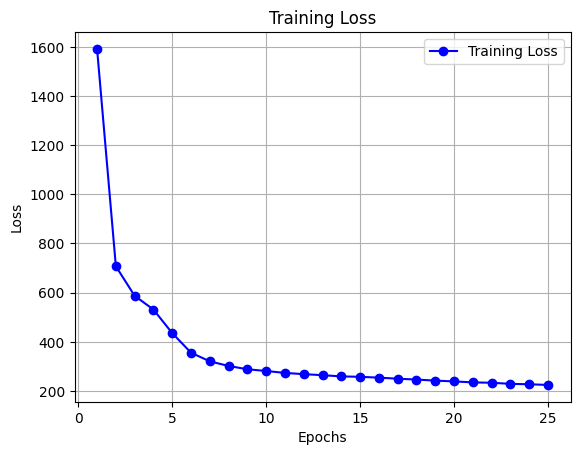

In [ ]:
# prompt: create a chart for training loss and validation loss vs. epoch for the above squeezenet model

import matplotlib.pyplot as plt

train_losses = [1591.4806, 707.3731, 587.1299, 531.2893, 435.4360, 355.8101, 320.6027, 301.8531, 288.4374, 281.2997,
                273.5785, 268.5182, 264.3674, 259.3197, 257.6988, 254.3402, 250.0245, 246.5307, 242.2247, 238.9793,
                235.0426, 233.5216, 229.1023, 227.2984, 224.7130]

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install torchviz


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

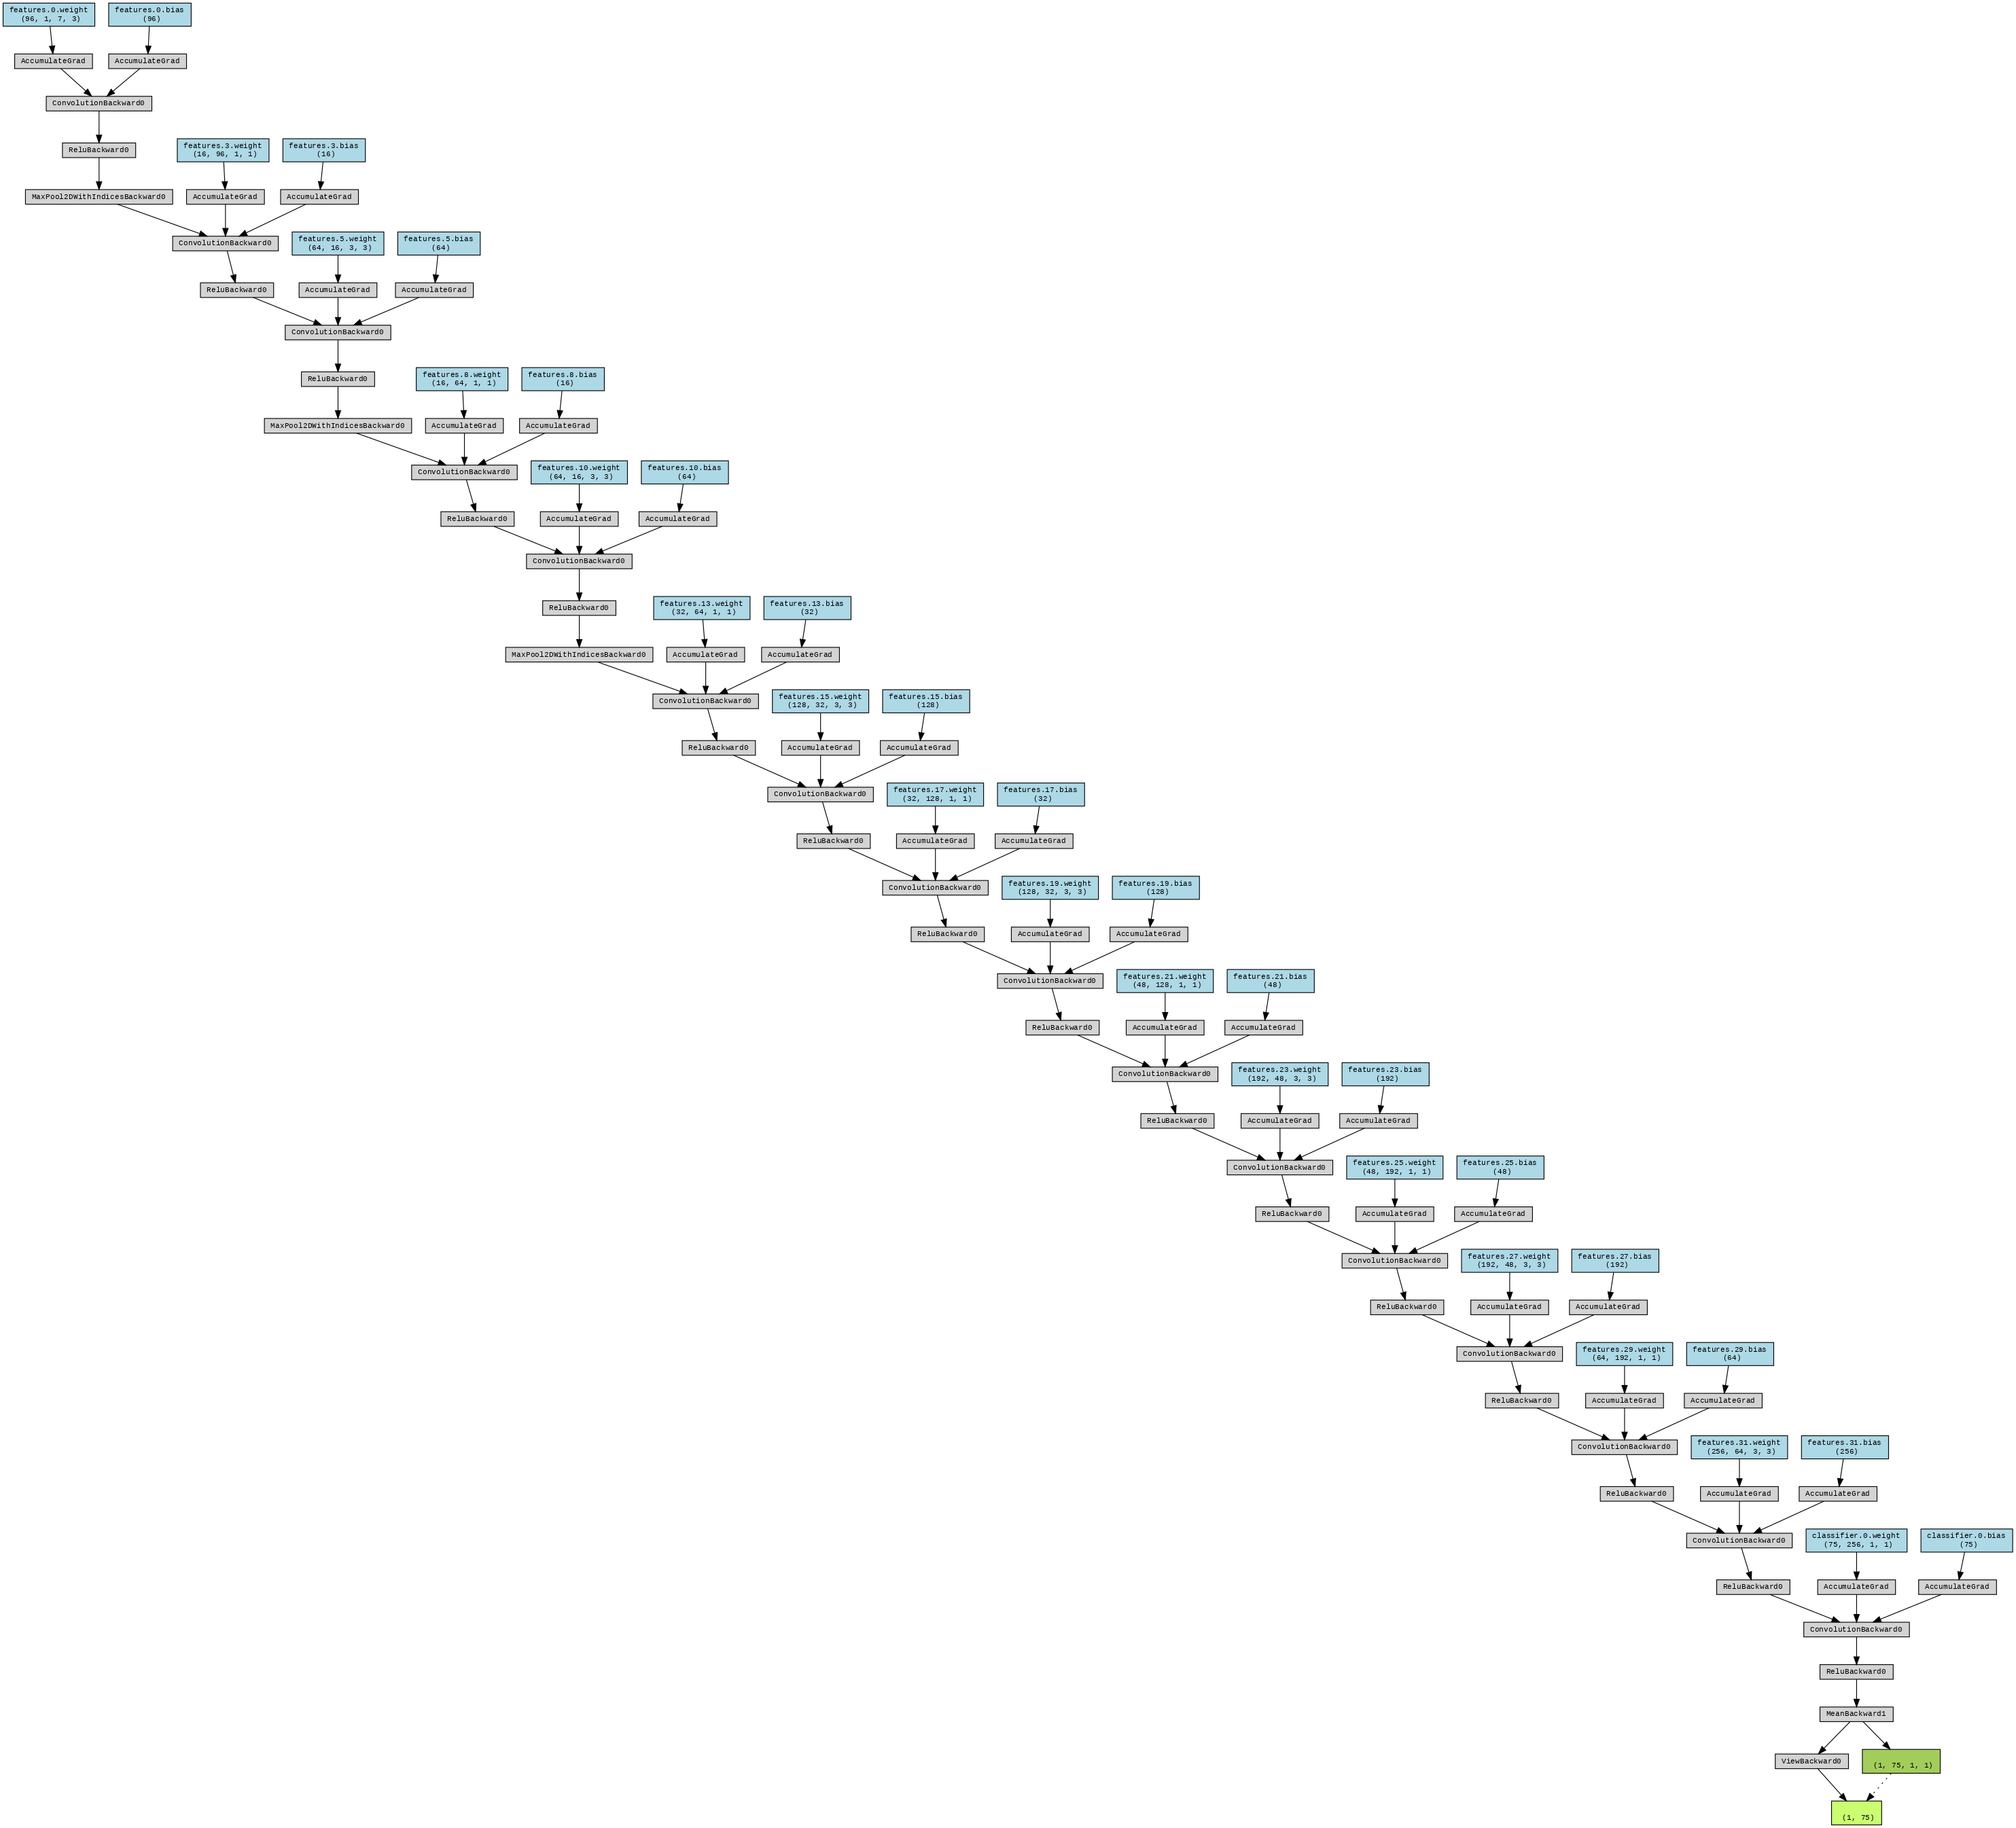

In [ ]:
import torch
from torchviz import make_dot

# Create a dummy input tensor
x = torch.randn(1, 1, 500, 12)

# Pass the dummy input through the model to get the output
model = SqueezeNetRegression()
output = model(x)

# Use torchviz to create a graph
graph = make_dot(output, params=dict(list(model.named_parameters()) + [('input', x)]))

# Save the graph to a file
graph.render("squeezenet_architecture", format="png")

# Display the graph
from IPython.display import Image
Image("squeezenet_architecture.png")

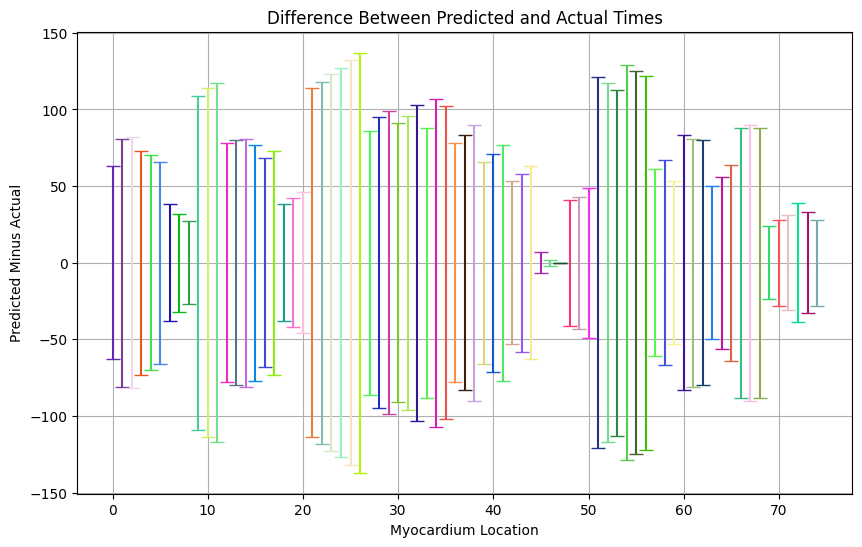

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchviz import make_dot
from IPython.display import Image

case_index = 3
input_data, actual_activation_time = get_test_case(case_index)

input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

#evaluation
model.eval()

#prediction
with torch.no_grad():
    prediction = model(input_tensor).numpy().flatten()

#difference between predicted and actual
differences = prediction - actual_activation_time.flatten()

# error bar plot w/ random colors
plt.figure(figsize=(10, 6))
for i in range(75):
    plt.errorbar(i, prediction[i], yerr=np.abs(differences[i]), fmt=' ', capsize=5, color=np.random.rand(3,))
plt.xlabel('Myocardium Location')
plt.ylabel('Predicted Minus Actual')
plt.title('Difference Between Predicted and Actual Times')
plt.grid(True)
plt.show()
